In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

# All the flows
import tensorflow as tf
from tensorflow import keras
from tqdm.notebook import tqdm

import bayesflow as bf

In [5]:
# Constants
DISPLAY_X, DISPLAY_Y = 2560, 1080

In [7]:
#Read in the data
dataset = pd.read_csv('../data/full_data2.csv', delimiter=";")
dataset.shape

(194758, 17)

Dataset:

* Timestamp
* Lap_Number (0,1)
* Position.x., Position.y., Position.z. (Drone position in world)
* Orientation.y. (0-360, yaw rotation)
* Gaze_Location.x., .y., .z. (original 3D gaze point)
* Subject
* Gaze.x. (0-2560, screen-relative gaze coord)
* Gaze.y. (0-1080, screen-relative gaze coord)
* d_ang (change in Orientation.y.)
* ang_accel (change in d_ang)
* Gate_N (Upcoming gate #, can substitute for gaze point)
* Gate.x., .z. (Gate_N position in world) 
* Ang_Pos (0:360, angle between Orientation.y. and normal vector of upcoming gate)

In [8]:
# Inspecting the data
dataset.head(5)

,Timestamp,Lap_Number,Position.x.,Position.z.,Orientation.y.,Gaze_Location.x.,Gaze_Location.y.,Gaze_Location.z.,Subject,Gaze.x.,Gaze.y.,d_ang,ang_accel,Gate_N,Gate.x.,Gate.z.,Ang_Pos
0,1688764397682,0,-255.4,-181.8494,-3.000000e-08,-270.743971,351.035293,-138.685157,1,1157.282,434.3420,-1.764706e-07,2.209487e-06,1,-261.2452,-135.0596,0.654205
1,1688764397699,0,-255.4,-181.7235,0.000000e+00,-270.748529,351.077679,-138.680800,1,1157.288,434.6814,-1.764706e-07,3.604383e-09,1,-261.2452,-135.0596,0.659015
2,1688764397715,0,-255.4,-181.5985,0.000000e+00,-270.753086,351.120064,-138.676443,1,1157.295,435.0208,-9.803922e-09,3.604383e-09,1,-261.2452,-135.0596,0.652319
3,1688764397732,0,-255.4,-181.4766,0.000000e+00,-270.460614,351.141679,-138.868614,1,1159.131,435.3366,-9.803922e-09,-1.099337e-06,1,-261.2452,-135.0596,0.634254
4,1688764397748,0,-255.4,-181.3582,0.000000e+00,-270.292557,351.172114,-138.796529,1,1160.693,435.5298,-9.803922e-09,-6.127451e-08,1,-261.2452,-135.0596,0.614264


In [10]:
# Determine the number of subjects
subjects = np.unique(dataset['Subject'].to_numpy())
subjects

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [11]:
lap_number = np.unique(dataset['Lap_Number'].to_numpy())
lap_number

array([0, 1])

In [12]:
subject_3_data = dataset[dataset['Subject'] == 3]
subject_3_data.shape

(13042, 17)

## Data exploration: hierarchical structure

<Axes: xlabel='Gaze.x.', ylabel='Gaze.y.'>

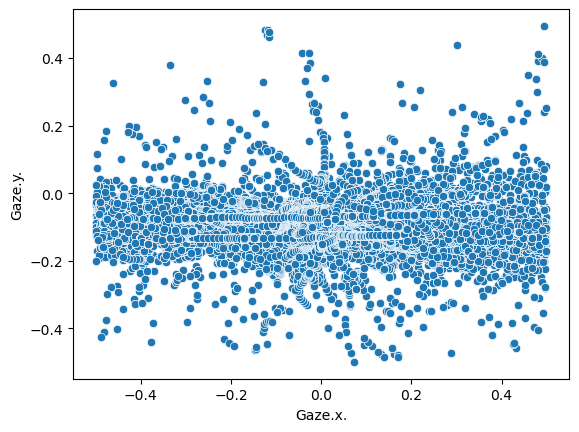

In [63]:
gaze_data = dataset[['Gaze.x.', 'Gaze.y.', 'Ang_Pos', 'Subject', 'Lap_Number']]
gaze_data.loc[:,'Gaze.x.'] = gaze_data.loc[:,'Gaze.x.'] / DISPLAY_X - 0.5
gaze_data.loc[:,'Gaze.y.'] = gaze_data.loc[:,'Gaze.y.'] / DISPLAY_Y - 0.5

sns.scatterplot(x=gaze_data['Gaze.x.'], y=gaze_data['Gaze.y.'])

In [30]:
def plot_gaze_by_axis(param, bins=50):
    f, axs = plt.subplots(4, 4, figsize=(14, 10))

    for i in range(len(subjects)):
        j, k = int(np.floor(i/4)), i%4
        subject_data = gaze_data[gaze_data['Subject'] == (i + 1)]
        subject_gaze = subject_data[param].to_numpy()
        sns.histplot(subject_gaze, bins=bins, ax=axs[j, k], color="maroon")
        axs[j, k].set_title('Subject {id}'.format(id = i + 1))
        axs[j, k].set_xlabel(param)

    axs.flat[len(subjects)] = sns.histplot(gaze_data[param].to_numpy(), bins=bins, color="purple")
    axs.flat[len(subjects)].set_title('All Subjects')
    axs.flat[len(subjects)].set_xlabel(param)
    plt.tight_layout()

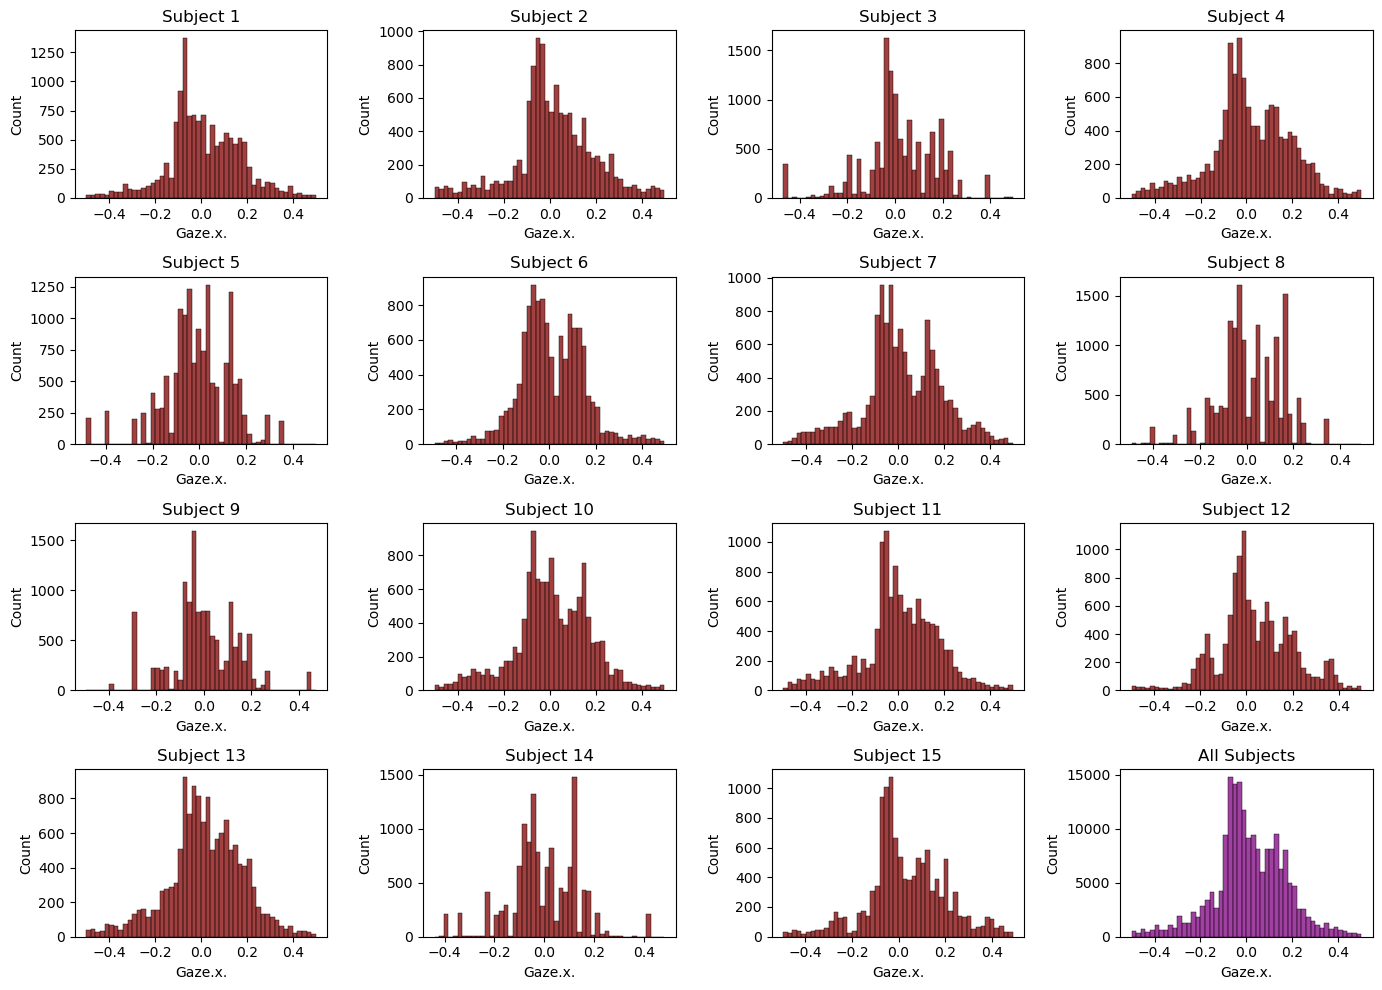

In [31]:
plot_gaze_by_axis('Gaze.x.', bins=50)

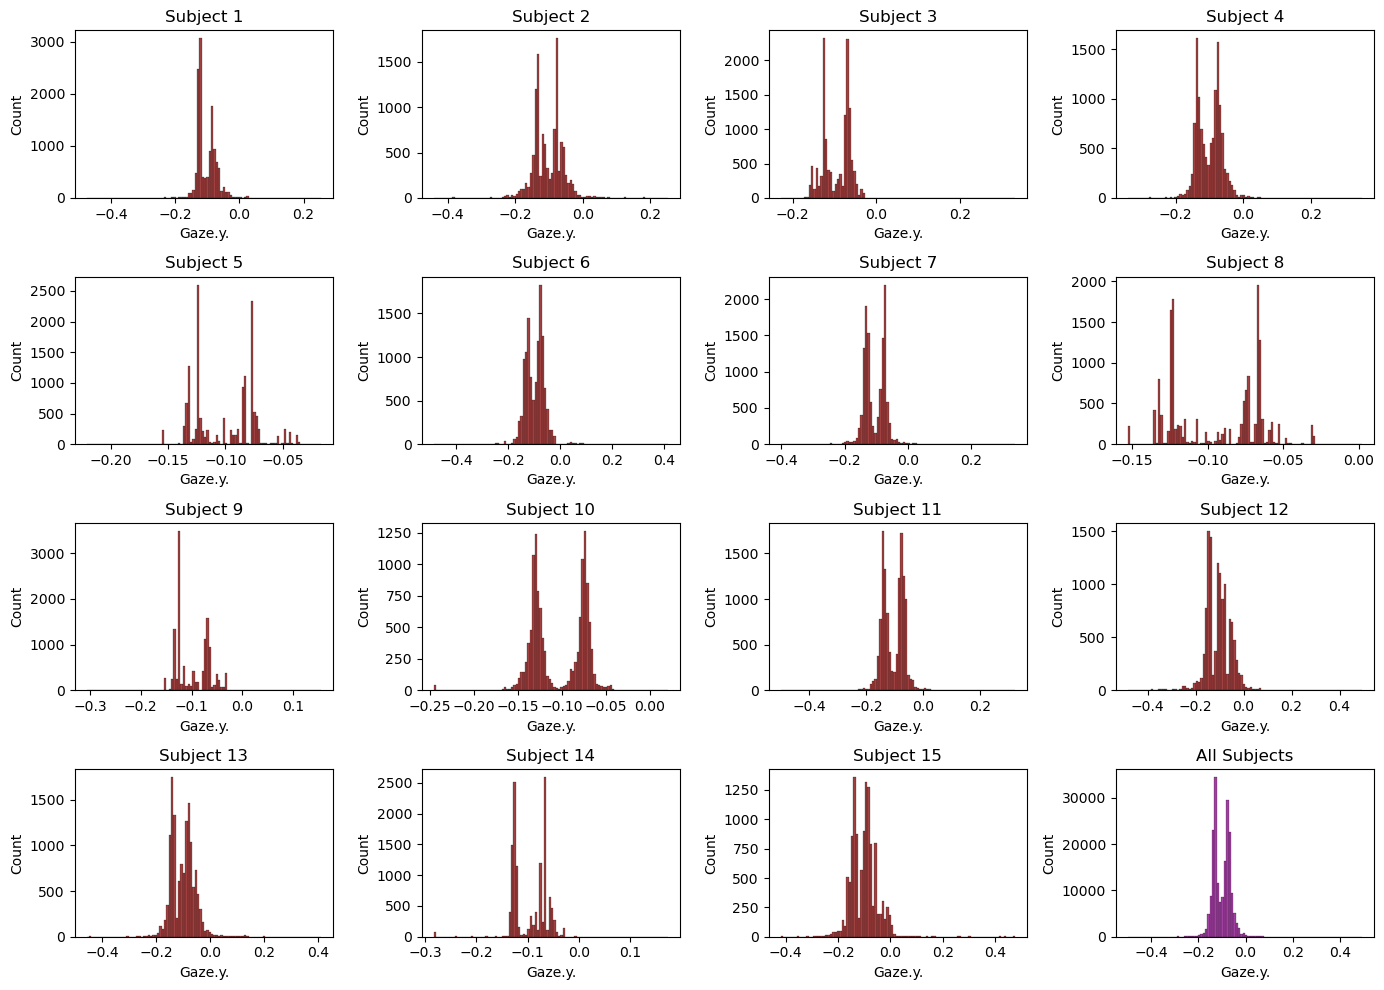

In [32]:
plot_gaze_by_axis('Gaze.y.', bins=100)

In [33]:
def plot_gaze_by_angles(param, bins=50):
    f, axs = plt.subplots(4, 4, figsize=(14, 10))

    for i in range(len(subjects)):
        j, k = int(np.floor(i/4)), i%4
        subject_data = gaze_data[gaze_data['Subject'] == (i + 1)]
        subject_gaze = subject_data[param].to_numpy()
        sns.histplot(subject_gaze, bins=bins, ax=axs[j, k], color="maroon")
        axs[j, k].set_title('Subject {id}'.format(id = i + 1))
        axs[j, k].set_xlabel(param)

    axs.flat[len(subjects)] = sns.histplot(gaze_data[param].to_numpy(), bins=bins, color="purple")
    axs.flat[len(subjects)].set_title('All Subjects')
    axs.flat[len(subjects)].set_xlabel(param)
    plt.tight_layout()

Interestingly, the gaze data from both x- and y-axis exhibits the mixture-distributed characteristics.

In [34]:
def gaze_simulator_test():
    pass

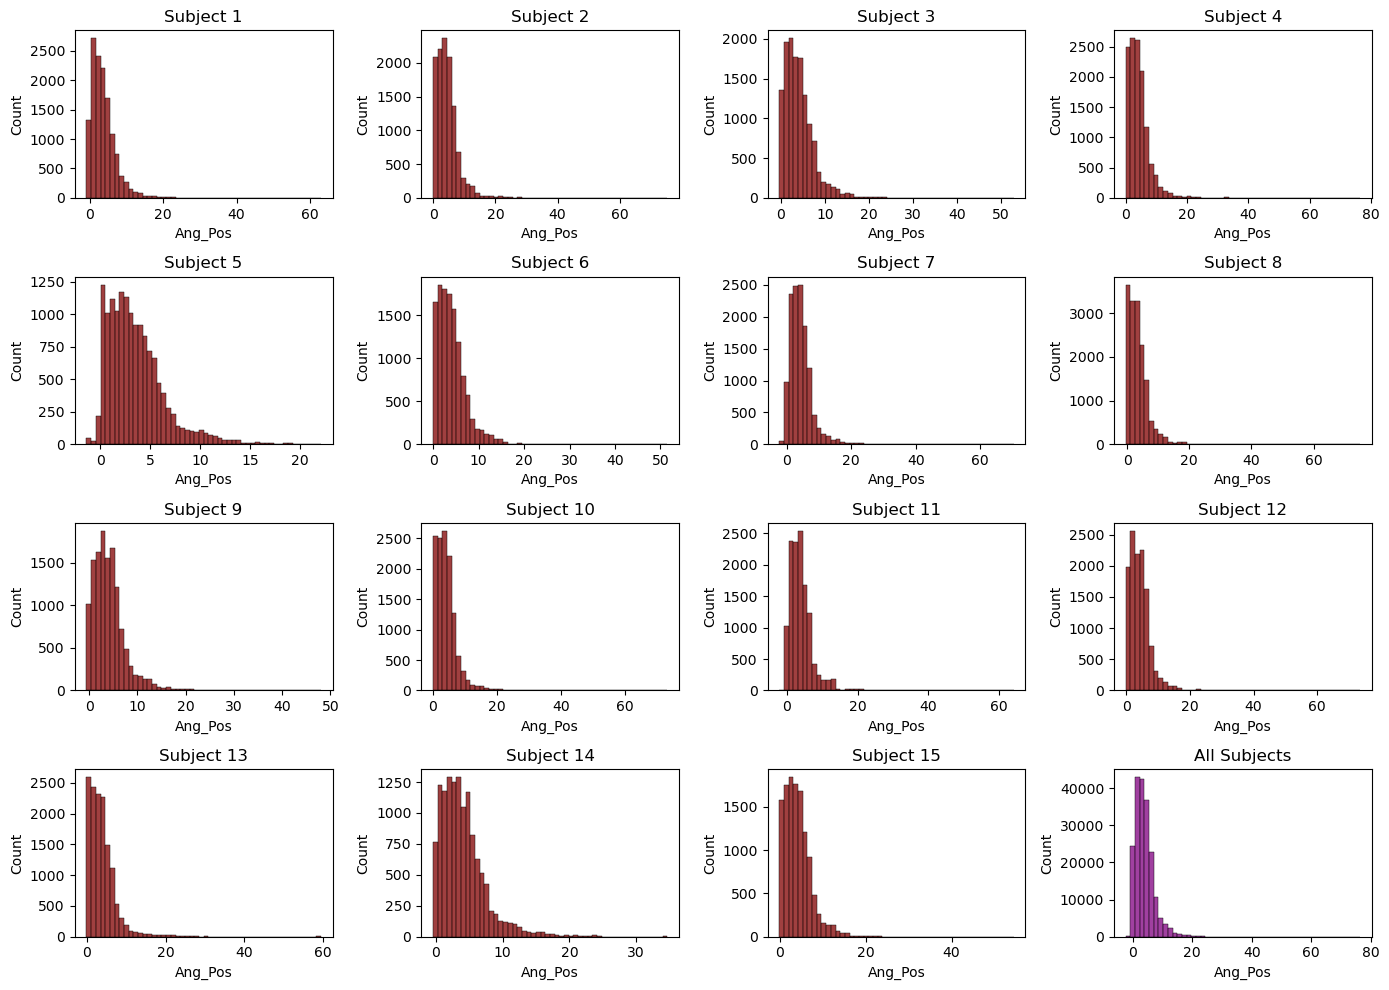

In [64]:
plot_gaze_by_axis('Ang_Pos')

<Axes: xlabel='Ang_Pos', ylabel='Gaze.x.'>

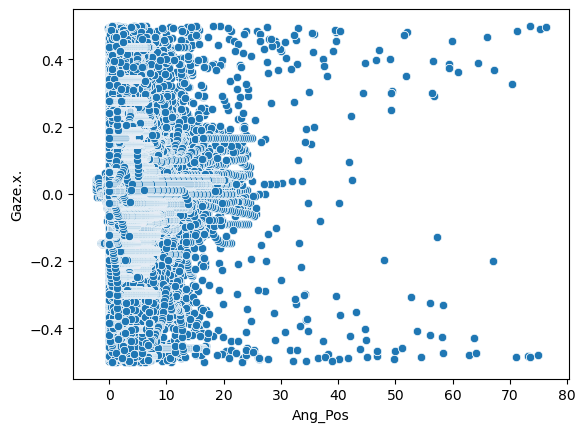

In [65]:
sns.scatterplot(x=gaze_data['Ang_Pos'], y=gaze_data['Gaze.x.'])

## Model formulation

Both x and y exhibit Gaussian mixture of 2 components each. For each subject $k = 1, ..., K$, the model can be formulated as

\begin{align}
    \eta_{x, k} &\sim \mathcal{N}(0, 1) \\
    \eta_{y, k} &\sim \mathcal{N}(0, 0.01) \\    
    \rho_{x, k}, \rho_{y, k} &\sim \mathrm{Gamma}(2, 2) \\
    \mu_x | k, \mu_y | k &\sim \mathcal{N}(\eta_{k}, \rho_{k}) \\
    \sigma_x | k, \sigma_y | k &\sim \mathrm{Gamma}(2, 2) \\
    \phi_x | k, \phi_y | k &\sim \mathcal{U}(0, 1), \\
    x &\sim \phi_x \mathcal{N}(\mu_{x, 1}, \sigma_{x, 1}) + (1 - \phi_x) \mathcal{N}(\mu_{x, 2}, \sigma_{x, 2}), \\
    y &\sim \phi_y \mathcal{N}(\mu_{y, 1}, \sigma_{y, 1}) + (1 - \phi_y) \mathcal{N}(\mu_{y, 2}, \sigma_{y, 2}).
\end{align}

In [ ]:
# def hyperprior_fun(rng=None):
#     if rng is None:
#         rng = np.random.default_rng()

In [ ]:
def prior_fun(rng=None):
    """
    Generate prior parameters for vertical gaze distribution.
    """
    if rng is None:
        rng = np.random.default_rng()
        

    phi = rng.uniform(0, 1, size=2)
    mu_x = rng.normal()
    sigma = rng.gamma(2, 2)

    theta = np.array([mu, sigma])

    return theta

In [11]:
#Normalize (x,y) to 0-1
gaze_x = dataset['Gaze.x.'] / 2560
gaze_y = dataset['Gaze.y.'] / 1080

gaze_x.max(), gaze_y.max()